Parte 1: Importação dos Arquivos

Em primeiro lugar, eu vou extrair a pasta do arquivo zip. Logo é preciso baixar no Colab o arquivo zip para fazer a extração da pasta.

In [1]:
import zipfile

# Nome do arquivo zip (mude se for diferente)
zip_path = "data\Acordes.zip"

# Caminho de destino para extração
extract_path = "data"

# Extraindo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


<>:4: SyntaxWarning: invalid escape sequence '\A'
<>:4: SyntaxWarning: invalid escape sequence '\A'
C:\Users\Ismael Soares\AppData\Local\Temp\ipykernel_6652\4121574443.py:4: SyntaxWarning: invalid escape sequence '\A'
  zip_path = "data\Acordes.zip"


Parte 2: Extração de atributos

Nessa parte eu vou usar a biblioteca librosa, que é própria para usar com arquivos de áudio.
https://librosa.org/doc/latest/generated/librosa.feature.mfcc.html#librosa.feature.mfcc

In [19]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração inicial
pasta = 'data/Acordes/Acordes'
lista_arquivos = os.listdir(pasta)
arquivos_audio = []

# Filtra arquivos .wav de acordes maiores/menores
for arquivo in lista_arquivos:
    if (arquivo.startswith('Major') or arquivo.startswith('Minor')) and arquivo.endswith('.wav'):
        arquivos_audio.append(os.path.join(pasta, arquivo))

dataset = []

for filepath in arquivos_audio:
    y, sr = librosa.load(filepath, sr=None)
    
    # --- Atributos temporais ---
    rms = librosa.feature.rms(y=y).mean()
    
    # --- Atributos espectrais ---
    # Chroma (prioridade máxima para acordes)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = chroma_stft.mean()
    chroma_stft_std = chroma_stft.std()
    
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma_cqt_mean = chroma_cqt.mean()
    chroma_cqt_std = chroma_cqt.std()
    
    # Tonnetz (relações harmônicas)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    tonnetz_mean = tonnetz.mean(axis=1)
    
    # MFCCs (timbre)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=5)
    mfcc_means = [mfcc[i].mean() for i in range(3)]  # Pegamos apenas os 3 primeiros coeficientes
    
    # --- Novos atributos sugeridos ---
    # Razão harmônica/percussiva
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    harmonic_ratio = np.mean(y_harmonic ** 2) / (np.mean(y_harmonic ** 2) + np.mean(y_percussive ** 2))
    
    # --- Classe ---
    filename = os.path.basename(filepath)
    classe = 'major' if filename.startswith('Major') else 'minor'
    
    # Armazena os atributos
    data = {
        'filename': filename,
        'rms': rms,
        'chroma_stft_mean': chroma_stft_mean,
        'chroma_stft_std': chroma_stft_std,
        'chroma_cqt_mean': chroma_cqt_mean,
        'chroma_cqt_std': chroma_cqt_std,
        'tonnetz_t1': tonnetz_mean[0],
        'tonnetz_t2': tonnetz_mean[1],
        'tonnetz_t3': tonnetz_mean[2],
        'tonnetz_t4': tonnetz_mean[3],
        'tonnetz_t5': tonnetz_mean[4],
        'tonnetz_t6': tonnetz_mean[5],
        'mfcc1': mfcc_means[0],
        'mfcc2': mfcc_means[1],
        'mfcc3': mfcc_means[2],
        'harmonic_ratio': harmonic_ratio,
        'class': classe
    }
    
    dataset.append(data)

# Converte para DataFrame
df = pd.DataFrame(dataset)

c:\Users\Ismael Soares\Documents\Faculdade\Reconhecimento de Padrões\Acordes-Maiores-e-Menores-KNN\acordesvenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=776
  warnings.warn(
c:\Users\Ismael Soares\Documents\Faculdade\Reconhecimento de Padrões\Acordes-Maiores-e-Menores-KNN\acordesvenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=758
  warnings.warn(
c:\Users\Ismael Soares\Documents\Faculdade\Reconhecimento de Padrões\Acordes-Maiores-e-Menores-KNN\acordesvenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=793
  warnings.warn(


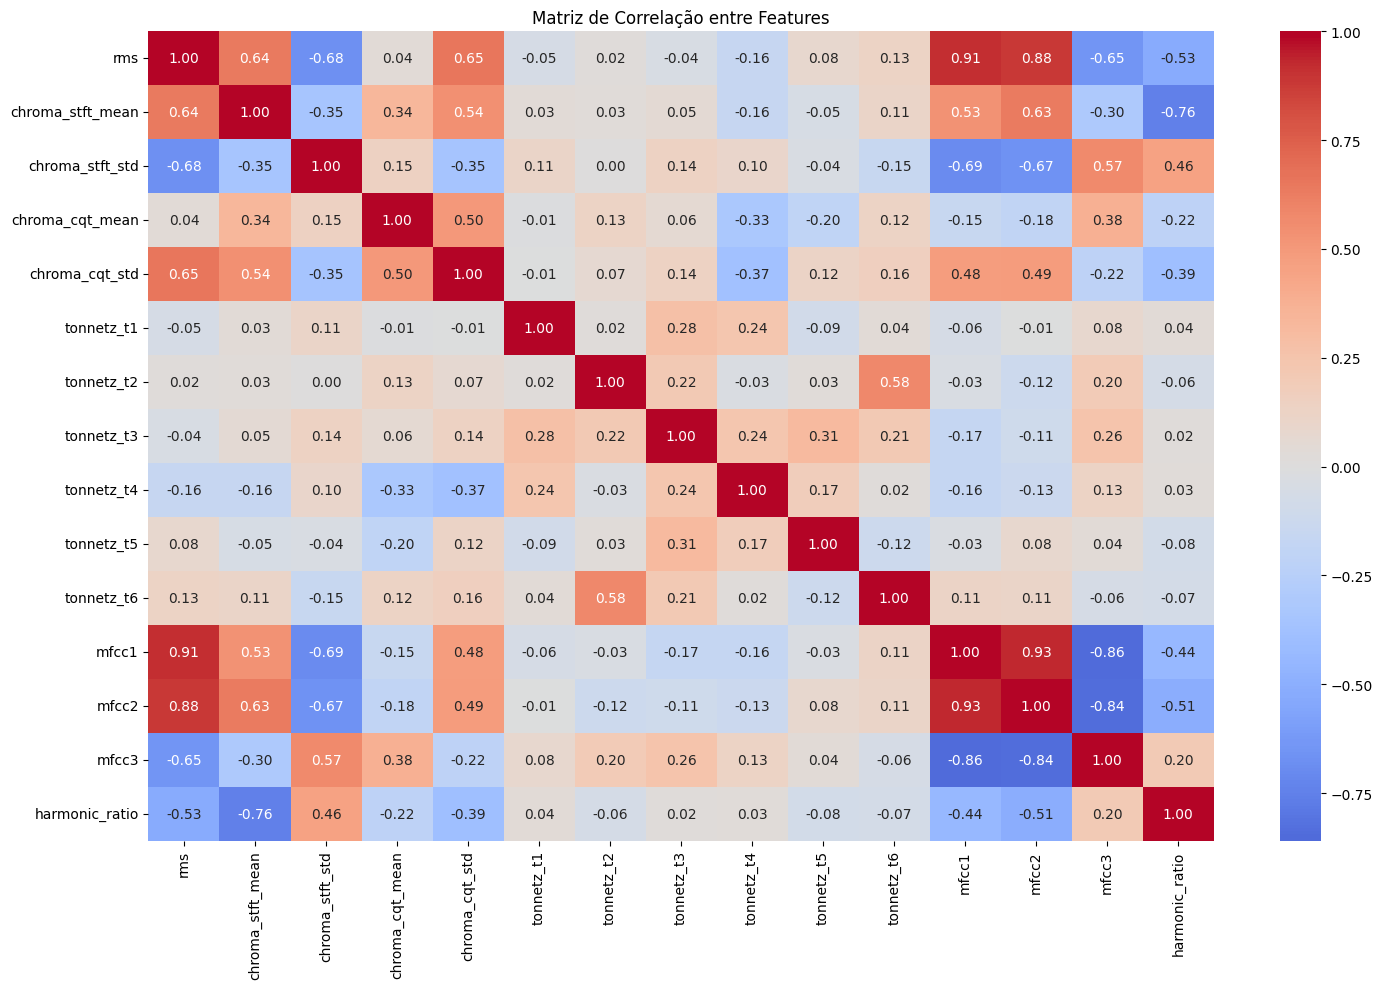

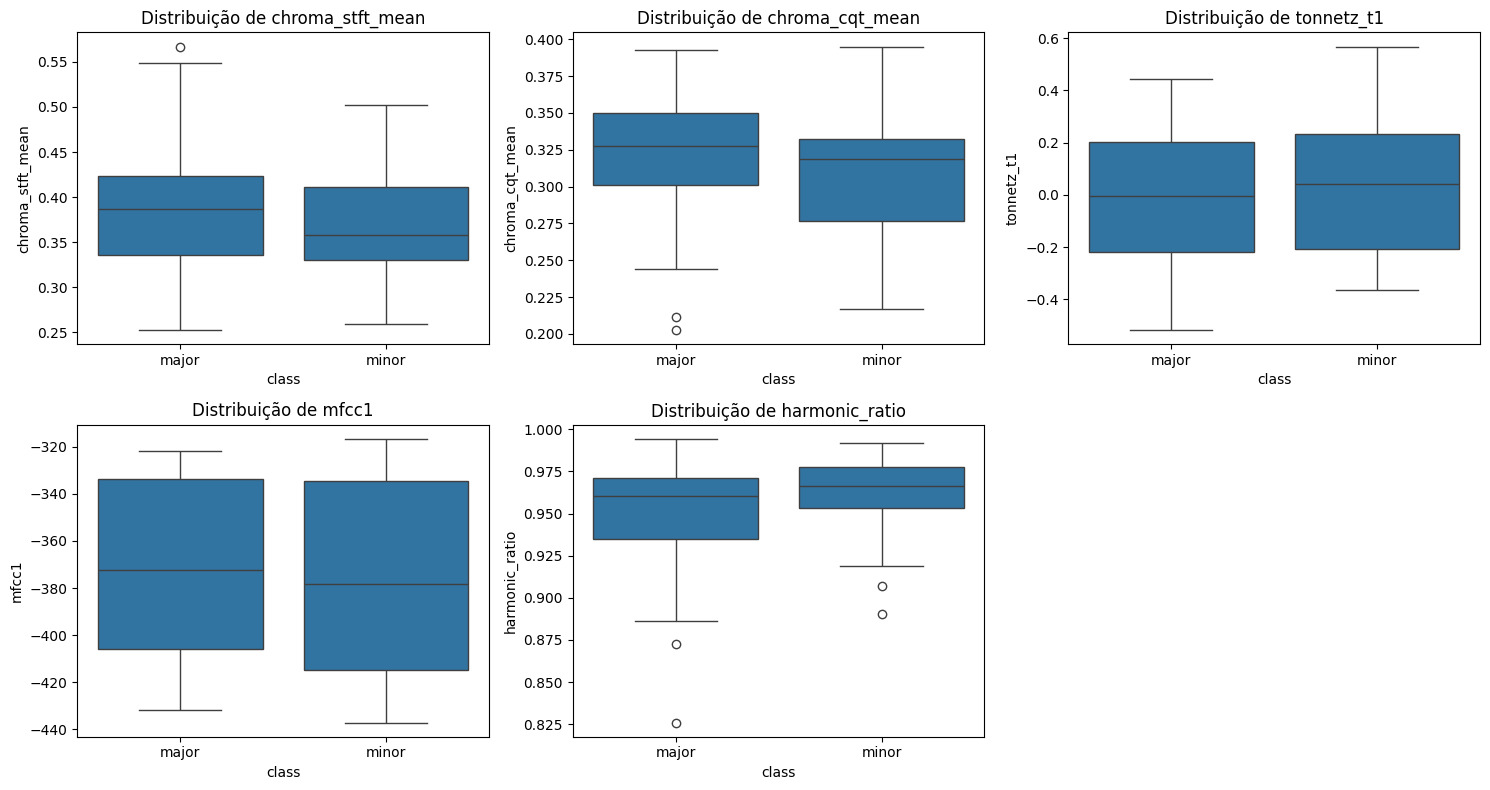

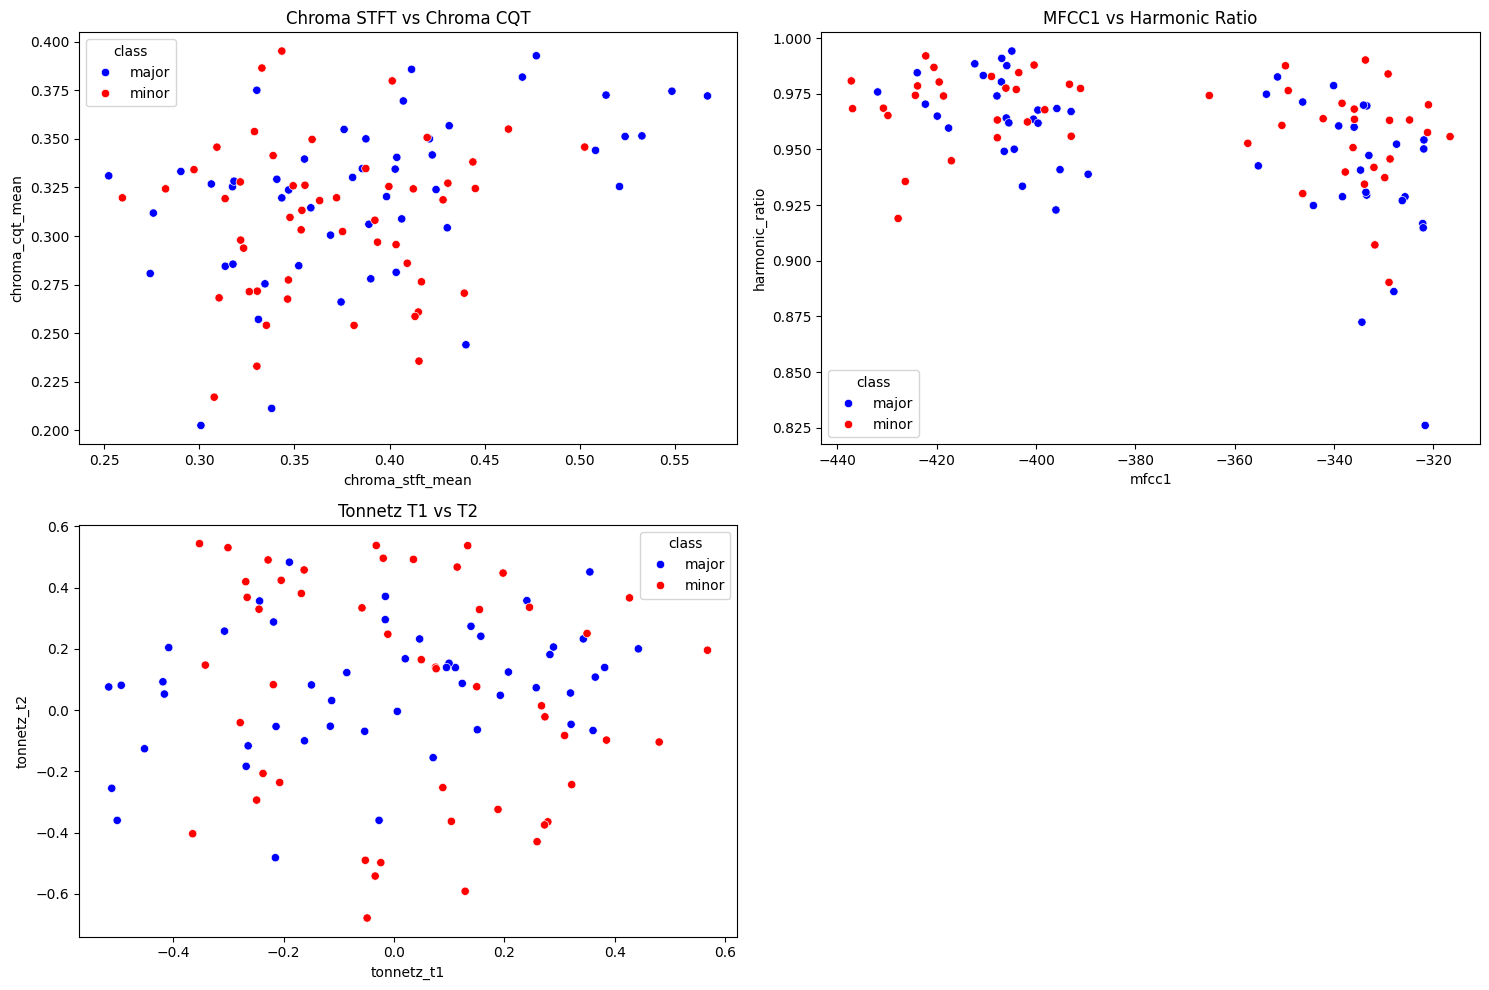

In [20]:
# --- Análise Exploratória ---

# 1. Matriz de Correlação entre Features
plt.figure(figsize=(15, 10))
corr = df.drop(['filename', 'class'], axis=1).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlação entre Features')
plt.tight_layout()
plt.show()

# 2. Boxplots por Classe para Features Principais
features_principais = ['chroma_stft_mean', 'chroma_cqt_mean', 'tonnetz_t1', 'mfcc1', 'harmonic_ratio']

plt.figure(figsize=(15, 8))
for i, feature in enumerate(features_principais, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='class', y=feature, data=df)
    plt.title(f'Distribuição de {feature}')
plt.tight_layout()
plt.show()

# 3. Gráficos de Dispersão para Relacionamento entre Features
plt.figure(figsize=(15, 10))

# Chroma STFT vs Chroma CQT
plt.subplot(2, 2, 1)
sns.scatterplot(x='chroma_stft_mean', y='chroma_cqt_mean', hue='class', data=df, palette={'major': 'blue', 'minor': 'red'})
plt.title('Chroma STFT vs Chroma CQT')

# MFCC1 vs Harmonic Ratio
plt.subplot(2, 2, 2)
sns.scatterplot(x='mfcc1', y='harmonic_ratio', hue='class', data=df, palette={'major': 'blue', 'minor': 'red'})
plt.title('MFCC1 vs Harmonic Ratio')

# Tonnetz T1 vs T2
plt.subplot(2, 2, 3)
sns.scatterplot(x='tonnetz_t1', y='tonnetz_t2', hue='class', data=df, palette={'major': 'blue', 'minor': 'red'})
plt.title('Tonnetz T1 vs T2')

plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Caminho dos arquivos
pasta = "data/Acordes/Acordes"  # substitua pelo seu caminho real
lista_arquivos = os.listdir(pasta)
arquivos_audio = []

# Filtrar arquivos que são maior ou menor
for arquivo in lista_arquivos:
    if (arquivo.startswith('Major') or arquivo.startswith('Minor')) and arquivo.endswith('.wav'):
        arquivos_audio.append(os.path.join(pasta, arquivo))

dataset = []

for filepath in arquivos_audio:
    y, sr = librosa.load(filepath, sr=None)  # Carrega o arquivo com librosa para extrair features avançadas
    
    # Extrair as features especificadas
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = np.mean(chroma_stft)
    
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma_cqt_mean = np.mean(chroma_cqt)
    
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    tonnetz_t1 = tonnetz[0].mean()  # Primeiro coeficiente Tonnetz
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    mfcc1 = mfcc[0].mean()  # Primeiro coeficiente MFCC
    
    harmonic_ratio = librosa.effects.harmonic(y)
    
    filename = os.path.basename(filepath)
    classe = '1' if filename.startswith('Major') else '0'

    dataset.append({
        'filename': filename,
        'class': classe,
        'chroma_stft_mean': chroma_stft_mean,
        'chroma_cqt_mean': chroma_cqt_mean,
        'tonnetz_t1': tonnetz_t1,
        'mfcc1': mfcc1,
        'harmonic_ratio': harmonic_ratio
    })

# Criar DataFrame
df = pd.DataFrame(dataset)

# Separar features e padronizar (normalização z-score)
features_principais = ['chroma_stft_mean', 'chroma_cqt_mean', 'tonnetz_t1', 'mfcc1', 'harmonic_ratio']
scaler = StandardScaler()
df_normalizado = df.copy()

c:\Users\Ismael Soares\Documents\Faculdade\Reconhecimento de Padrões\Acordes-Maiores-e-Menores-KNN\acordesvenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=776
  warnings.warn(
c:\Users\Ismael Soares\Documents\Faculdade\Reconhecimento de Padrões\Acordes-Maiores-e-Menores-KNN\acordesvenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=758
  warnings.warn(
c:\Users\Ismael Soares\Documents\Faculdade\Reconhecimento de Padrões\Acordes-Maiores-e-Menores-KNN\acordesvenv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=793
  warnings.warn(


Parte 4 : K-Fold

In [29]:
import numpy as np

def kfold_manual(df, k=10, seed=42):
    np.random.seed(seed)

    # Obtém os índices das amostras para cada classe
    index_menor = df[df['class'] == '0'].index.to_numpy()
    index_maior = df[df['class'] == '1'].index.to_numpy()

    # Embaralha os índices
    np.random.shuffle(index_menor)
    np.random.shuffle(index_maior)

    # Divide os índices em k partes (folds) de forma sequencial
    folds_menor = np.array_split(index_menor, k)
    folds_maior = np.array_split(index_maior, k)

    folds = []
    for i in range(k):
        fold = np.concatenate([folds_menor[i], folds_maior[i]])
        np.random.shuffle(fold)
        folds.append(fold)

    return folds

# Exemplo de uso:
folds = kfold_manual(df_normalizado)

for i, fold in enumerate(folds):
    print(f"Fold {i+1}: {fold}")

Fold 1: [95 89 67 29 46 38 45  2 63 80]
Fold 2: [75 69 39 76 44 98  0 82 10 22]
Fold 3: [49 62 54 33 58 87 53 18 21 30]
Fold 4: [24 91 97 12 32  4 65 31 56 96]
Fold 5: [81 26 42 84 20 66 59 74 14 23]
Fold 6: [94  9 15 77 36 41 55 83 50 40]
Fold 7: [28 79 71 61 37 11 17 86 48 51]
Fold 8: [52 85 93 16  3 47 73  5 90 35]
Fold 9: [72 68  7 70 43 13 60 99 34  6]
Fold 10: [ 1  8 92 19 27 64 57 88 78 25]
